In [1]:
import sys
sys.path.append("code")

# %load_ext autoreload

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb


In [3]:
from plotting import format_plot, save_plot

In [4]:
moon_polar_radius = 1736  # km

In [5]:
def generate_panels_wetterer(N):
    # N must be even, otherwise division by zero may occur in polar angle calculation (z=0)
    
    polars = []
    azimuths = []
    
    z = -1 + 1/N  # from 1 to -1
    for j in range(1, N+1):
        # Fraction is flipped compared to paper; the paper version biases points towards poles
        polars.append(np.pi/2 - np.arctan(z/np.sqrt(1-z**2)))
        if j == 1:
            azimuths.append(0.)
        else:
            azimuths.append(np.mod(azimuths[-1] + np.pi * (3-np.sqrt(5)), 2*np.pi))
        
        z += 2/N
    
    return azimuths, polars

generate_panels_wetterer(4)

([0.0, 2.399963229728653, 4.799926459457306, 0.9167043820063725],
 [2.4188584057763776,
  1.8234765819369751,
  1.318116071652818,
  0.7227342478134156])

In [6]:
def generate_panels_saff(N):
    polars = []
    azimuths = []
    
    for k in range(1, N+1):
        h = -1 + 2 * (k-1) / (N-1)  # from 1 to -1
        polars.append(np.arccos(h))
        if k == 1 or k == N:
            azimuths.append(0.)
        else:
            azimuths.append(np.mod(azimuths[-1] + 3.6 / np.sqrt(N * (1-h**2)), 2*np.pi))
        
    return azimuths, polars

generate_panels_saff(4)

([0.0, 1.9091883092036783, 3.8183766184073566, 0.0],
 [3.141592653589793, 1.9106332362490186, 1.2309594173407747, 0.0])

In [7]:
def calculate_cap_polar_angle(h):
    return np.arccos(moon_polar_radius / (h + moon_polar_radius))

np.degrees(calculate_cap_polar_angle(50))

13.589401732489542

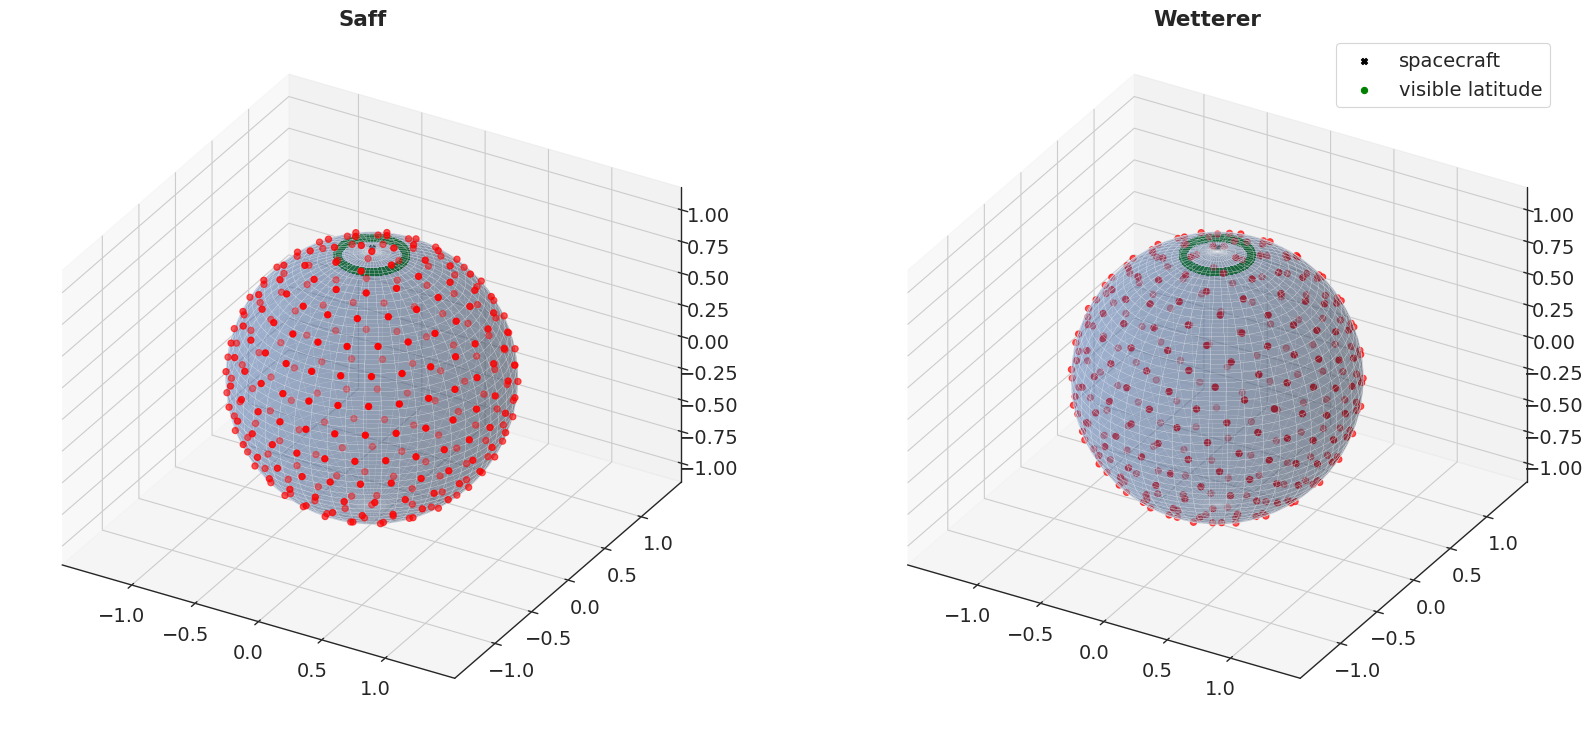

In [8]:
def plot_sphere():
    def polar2cart(u, v):
        # u=azimuth, v=polar
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        return x, y, z
    
    def _do_plot(ax, generate_fn):
        u, v = np.mgrid[0:2*np.pi:200j, 0:np.pi:100j]

        ax.plot_surface(*polar2cart(u, v), alpha=0.3, linewidth=0.1)
        
        panels = generate_fn(290)
        ax.scatter(*polar2cart(*panels), c="red")
        
        h = 50
        cap_polar = calculate_cap_polar_angle(h)
        ax.scatter(0, 0, (h + moon_polar_radius) / moon_polar_radius, marker="X", c="black", label="spacecraft")
        ax.scatter(*polar2cart(u, cap_polar), c="green", label="visible latitude")
        
        ax.set_aspect("equal")
    
    fig, (ax_saff, ax_wetterer) = plt.subplots(1, 2, figsize=[20, 10],
                                    subplot_kw={"projection": "3d", "proj_type": "ortho"})

    _do_plot(ax_saff, generate_panels_saff)
    _do_plot(ax_wetterer, generate_panels_wetterer)

    ax_saff.set_title("Saff")
    ax_wetterer.set_title("Wetterer")
    
    plt.legend()
    
plot_sphere()

In [9]:
def calculate_required_N(n, cap_polar_angle):
    cap_area = 2 * np.pi * moon_polar_radius**2 * (1 - np.cos(cap_polar_angle))
    sphere_area = 4 * np.pi * moon_polar_radius**2
    N = n / cap_area * sphere_area
    return np.ceil(N)

calculate_required_N(40, calculate_cap_polar_angle(38))

3735.0

In LRO's orbit, ~2858 panels would be necessary that at least 40 panels are visible at all times, as recommended by Wetterer 2014.

In [10]:
def calculate_visible_n(N, cap_polar_angle):
    cap_area = 2 * np.pi * moon_polar_radius**2 * (1 - np.cos(cap_polar_angle))
    sphere_area = 4 * np.pi * moon_polar_radius**2
    n = N * cap_area / sphere_area
    return np.ceil(n)

calculate_visible_n(2000, calculate_cap_polar_angle(38))

22.0

At LRO's minimum altitude of 38 km, 22 panels are visible when the moon is paneled with 2000 panels.

## Unit test data

In [11]:
def generate_unit_test_data_saff():
    azimuths, polars = generate_panels_saff(10)
    print(",\n".join(map(str, polars)))
    print()
    print(",\n".join(map(str, azimuths)))
    
generate_unit_test_data_saff()

3.141592653589793,
2.4619188346815495,
2.1598272970111707,
1.9106332362490186,
1.6821373411358607,
1.4594553124539327,
1.2309594173407747,
0.9817653565786227,
0.6796738189082441,
0.0

0.0,
1.8112150617748297,
3.180364954435027,
4.387841662284913,
5.53335464780712,
0.39568232614974086,
1.6031590339996273,
2.9723089266598244,
4.783523988434654,
0.0


In [12]:
def generate_unit_test_data_wetterer():
    azimuths, polars = generate_panels_wetterer(10)
    print(",\n".join(map(str, polars)))
    print()
    print(",\n".join(map(str, azimuths)))
    
generate_unit_test_data_wetterer()

2.6905658417935308,
2.34619382340565,
2.0943951023931953,
1.8754889808102941,
1.6709637479564563,
1.4706289056333366,
1.266103672779499,
1.0471975511965974,
0.7953988301841433,
0.4510268117962619

0.0,
2.399963229728653,
4.799926459457306,
0.9167043820063725,
3.3166676117350256,
5.716630841463679,
1.833408764012745,
4.2333719937413985,
0.35014991629046577,
2.750113146019119
